<a href="https://www.kaggle.com/code/pachecopacheco4/survival-titanic-2-0?scriptVersionId=148628933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Trying to use more information 

In this ocassion we are going to try to obtain more information by analyzing 'Ticket', 'Name' and 'Cabin' variables. We ommit some steps made in Survival Titanic (past notebook).  

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

 We are going to do an election that tends to predict 'Survived'.
 We thought that likely that are families that have more survival rate than others. For this reason we are going to create 'Family' variable that is going to save the last name of the passengers. 

In [3]:
titanic2=titanic.copy()
titanic2['Family'] = [c.split(',')[0] for c in titanic2.Name]
titanic2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


In [4]:
a=titanic.pivot_table(index='Cabin', columns='Survived', aggfunc='size', fill_value=0)
a.columns=['NotSurvived','Survived']
a2=a[a['Survived']>0].copy()
a2['SurvivedPercentage'] = (a2['Survived'] / a2.sum(axis=1)) * 100
a2

,NotSurvived,Survived,SurvivedPercentage
Cabin,,,
A16,0,1,100.000000
A20,0,1,100.000000
A23,0,1,100.000000
A26,0,1,100.000000
A31,0,1,100.000000
...,...,...,...
F E69,0,1,100.000000
F2,1,2,66.666667
F33,0,3,100.000000


Although likely this contains some information we are going to ommit 'Cabin' variable again. 

In [5]:
b=titanic2.pivot_table(index='Family', columns='Survived', aggfunc='size', fill_value=0)
b.columns=['NotSurvived','Survived']
b2=b[b.Survived>2].copy()
b2['SurvivedPercentage'] = (b2['Survived'] / b2.sum(axis=1)) * 100
print(b2)
mostSurvivedFamilies=b2.reset_index()['Family']

          NotSurvived  Survived  SurvivedPercentage
Family                                             
Asplund             1         3           75.000000
Baclini             0         4          100.000000
Brown               1         3           75.000000
Carter              2         4           66.666667
Harper              1         3           75.000000
Johnson             3         3           50.000000
Kelly               1         3           75.000000
Richards            0         3          100.000000


Here we are going to delete family Brown and Johnson.

In [6]:
excluded_families = ['Brown','Johnson']

mostSurvivedFamilies = set(b2.index).difference(excluded_families)

mostSurvivedFamilies

{'Asplund', 'Baclini', 'Carter', 'Harper', 'Kelly', 'Richards'}

In [7]:
c=titanic.pivot_table(index='Ticket', columns='Survived', aggfunc='size', fill_value=0)
c.columns=['NotSurvived','Survived']
c2=c[c.Survived>=3].copy()
c2['SurvivedPercentage'] = (c2['Survived'] / c2.sum(axis=1)) * 100
print(c2)
mostSurvivedTickets=c2.index

          NotSurvived  Survived  SurvivedPercentage
Ticket                                             
110152              0         3          100.000000
113760              0         4          100.000000
13502               0         3          100.000000
1601                2         5           71.428571
17421               1         3           75.000000
24160               0         3          100.000000
2666                0         4          100.000000
29106               0         3          100.000000
347077              1         3           75.000000
347742              0         3          100.000000
PC 17572            0         3          100.000000
PC 17755            0         3          100.000000
PC 17757            1         3           75.000000


Here we are going to ommit 1601 Ticket (we would like to be strict in classifying).

In [8]:
excluded_tickets = ['1601']

mostSurvivedTickets = set(c2.index).difference(excluded_tickets)

mostSurvivedTickets

{'110152',
 '113760',
 '13502',
 '17421',
 '24160',
 '2666',
 '29106',
 '347077',
 '347742',
 'PC 17572',
 'PC 17755',
 'PC 17757'}

In [9]:
titanic2['NewFamily'] = titanic2['Family'].apply(lambda x: x if x in mostSurvivedFamilies else 'otherFamily')
titanic2['NewFamily'].unique()

array(['otherFamily', 'Asplund', 'Harper', 'Carter', 'Kelly', 'Richards',
       'Baclini'], dtype=object)

In [10]:
titanic2['NewTicket'] = titanic2['Ticket'].apply(lambda x: x if x in mostSurvivedTickets else 'otherTicket')
titanic2['NewTicket'].unique()

array(['otherTicket', '347742', '347077', 'PC 17572', '110152',
       'PC 17755', '13502', '17421', 'PC 17757', '113760', '29106',
       '2666', '24160'], dtype=object)

In [11]:
titanic2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,NewFamily,NewTicket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,otherFamily,otherTicket
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,otherFamily,otherTicket
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,otherFamily,otherTicket
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,otherFamily,otherTicket
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,otherFamily,otherTicket


In [12]:
y=titanic.Survived
X=titanic2[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','NewFamily','NewTicket']]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NewFamily,NewTicket
0,3,male,22.0,1,0,7.2500,S,otherFamily,otherTicket
1,1,female,38.0,1,0,71.2833,C,otherFamily,otherTicket
2,3,female,26.0,0,0,7.9250,S,otherFamily,otherTicket
3,1,female,35.0,1,0,53.1000,S,otherFamily,otherTicket
4,3,male,35.0,0,0,8.0500,S,otherFamily,otherTicket


### Imputation and one hot encoding 

In [13]:
X.isnull().sum()

Pclass         0
Sex            0
Age          177
SibSp          0
Parch          0
Fare           0
Embarked       2
NewFamily      0
NewTicket      0
dtype: int64

**Numerical imputation**

In [14]:
from sklearn.impute import SimpleImputer
X2 = X.copy()
my_imputer = SimpleImputer()
numerical_cols2 = [cname for cname in X2.columns if X2[cname].dtype in ['int64', 'float64']]
print(numerical_cols2)

X2[numerical_cols2] = pd.DataFrame(my_imputer.fit_transform(X2[numerical_cols2]))
X2[numerical_cols2].columns = X[numerical_cols2].columns

print(X2[numerical_cols2].isnull().sum())


['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


**Categorical imputation**

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
categorical_cols2 = [cname for cname in X2.columns if X2[cname].dtype == "object"]

In [16]:
my_imputer = SimpleImputer(strategy='most_frequent')
X2[categorical_cols2] = pd.DataFrame(my_imputer.fit_transform(X2[categorical_cols2]))
X2[categorical_cols2].columns = X[categorical_cols2].columns
X2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NewFamily,NewTicket
0,3.0,male,22.0,1.0,0.0,7.2500,S,otherFamily,otherTicket
1,1.0,female,38.0,1.0,0.0,71.2833,C,otherFamily,otherTicket
2,3.0,female,26.0,0.0,0.0,7.9250,S,otherFamily,otherTicket
3,1.0,female,35.0,1.0,0.0,53.1000,S,otherFamily,otherTicket
4,3.0,male,35.0,0.0,0.0,8.0500,S,otherFamily,otherTicket


**One hot encoding**

In [17]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(X2[categorical_cols2]))

OH_cols

OH_cols.index = X2.index
OH_cols

X2.drop(categorical_cols2, axis=1, inplace=True)

X2 = pd.concat([X2, OH_cols], axis=1)

X2.columns = X2.columns.astype(str)

In [18]:
X2.head()

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Train and validation sets

In [19]:
from sklearn.model_selection import train_test_split
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y, random_state = 35643419)

**XGBOOST**

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#xgbm = XGBClassifier(n_estimators=1000,max_leaves=50,random_state=35643419,early_stopping_rounds=5,learning_rate=0.05)
xgbm = XGBClassifier(n_estimators=150,max_leaves=50,random_state=35643419,learning_rate=0.05)

#xgbm.fit(train_X2, train_y2, eval_set=[(val_X2, val_y2)],verbose=False)
xgbm.fit(train_X2, train_y2)

preds_xgb2 = xgbm.predict(val_X2)

**Learning rate** 
- With early_stopping_rounds
1. default | 0.8340807174887892
2. 0.05 | 0.8430493273542601

- Without early_stopping_rounds
1. 0.05 | 0.8475336322869955

**max_leafs**

**lambda**

**gamma**


In [21]:
score = accuracy_score(val_y2, preds_xgb2)
print('Score:', score)
print(classification_report(val_y2, preds_xgb2))

Score: 0.8475336322869955
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       141
           1       0.83      0.73      0.78        82

    accuracy                           0.85       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.85      0.85      0.85       223



In [22]:
def get_accuracy(max_leaves, train_X, val_X, train_y, val_y):
    xgbm = XGBClassifier(n_estimators=1000,max_leaves=max_leaves,random_state=35643419,early_stopping_rounds=5)
    xgbm.fit(train_X, train_y, eval_set=[(val_X, val_y)],verbose=False)
    preds_xgb = xgbm.predict(val_X)
    accuracy = accuracy_score(val_y, preds_xgb)
    return(accuracy)

for max_leaves in [5, 50, 500, 5000]:
    print('max_leaves:',max_leaves,' accuracy:',get_accuracy(max_leaves, train_X2, val_X2, train_y2, val_y2))

max_leaves: 5  accuracy: 0.8340807174887892
max_leaves: 50  accuracy: 0.8340807174887892
max_leaves: 500  accuracy: 0.8340807174887892
max_leaves: 5000  accuracy: 0.8340807174887892


**DECISSION TREE**

In [23]:
from sklearn.tree import DecisionTreeClassifier

dtm = DecisionTreeClassifier(max_leaf_nodes=50,min_samples_split=4,random_state=35643419)

from sklearn.metrics import accuracy_score

dtm.fit(train_X2, train_y2)

# Preprocessing of validation data, get predictions
preds = dtm.predict(val_X2)

**max_depth**
1. 0.8385650224215246

**min_samples_split**
1. 5 | 0.8385650224215246
2. 4 | 0.8430493273542601 

**min_samples_leaf** 

In [24]:
score = accuracy_score(val_y2, preds)
print('Score:', score)
print(classification_report(val_y2, preds))

Score: 0.8430493273542601
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       141
           1       0.81      0.76      0.78        82

    accuracy                           0.84       223
   macro avg       0.83      0.82      0.83       223
weighted avg       0.84      0.84      0.84       223



In [25]:
def get_accuracy(max_leaf_nodes, train_X, val_X, train_y, val_y):
    dtm = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=35643419)
    dtm.fit(train_X, train_y)
    preds = dtm.predict(val_X)
    accuracy = accuracy_score(val_y, preds)
    return(accuracy)

for max_leaf_nodes in [5, 50, 500, 5000]:
    print('max_leaf_nodes:',max_leaf_nodes,' accuracy:',get_accuracy(max_leaf_nodes, train_X2, val_X2, train_y2, val_y2))

max_leaf_nodes: 5  accuracy: 0.8071748878923767
max_leaf_nodes: 50  accuracy: 0.8385650224215246
max_leaf_nodes: 500  accuracy: 0.7982062780269058
max_leaf_nodes: 5000  accuracy: 0.7982062780269058


**RANDOM FORESTS**

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfm = RandomForestClassifier(n_estimators=400,max_leaf_nodes=50,max_depth=10,min_samples_split=3,random_state=35643419)

rfm.fit(train_X2, train_y2)

preds_rf = rfm.predict(val_X2)

In [27]:
score = accuracy_score(val_y2, preds_rf)
print('Score:', score)
print(classification_report(val_y2, preds_rf))

Score: 0.852017937219731
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       141
           1       0.85      0.73      0.78        82

    accuracy                           0.85       223
   macro avg       0.85      0.83      0.84       223
weighted avg       0.85      0.85      0.85       223



**max_depth**
1. default | 0.8340807174887892
2. 5 | 0.8385650224215246
3. 10 | 0.8475336322869955

**min_samples_split**
1. 3 | 0.852017937219731
2. 5 | 0.8340807174887892

**min_samples_leaf**

In [28]:
def get_accuracy(max_leaf_nodes, train_X, val_X, train_y, val_y):
    rfm = RandomForestClassifier(n_estimators=5,max_leaf_nodes=max_leaf_nodes,random_state=35643419)
    rfm.fit(train_X, train_y)
    preds_rf = rfm.predict(val_X)
    accuracy = accuracy_score(val_y, preds_rf)
    return(accuracy)

for max_leaf_nodes in [5, 50, 500, 5000]:
    print('max_leaf_nodes:',max_leaf_nodes,' accuracy:',get_accuracy(max_leaf_nodes, train_X2, val_X2, train_y2, val_y2))

max_leaf_nodes: 5  accuracy: 0.7892376681614349
max_leaf_nodes: 50  accuracy: 0.8251121076233184
max_leaf_nodes: 500  accuracy: 0.7757847533632287
max_leaf_nodes: 5000  accuracy: 0.7757847533632287


**NEURAL NETWORK**

Best Validation Loss: 0.3992
Best Validation Accuracy: 0.8341


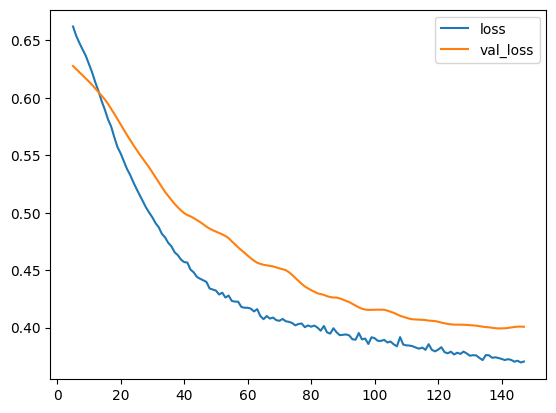

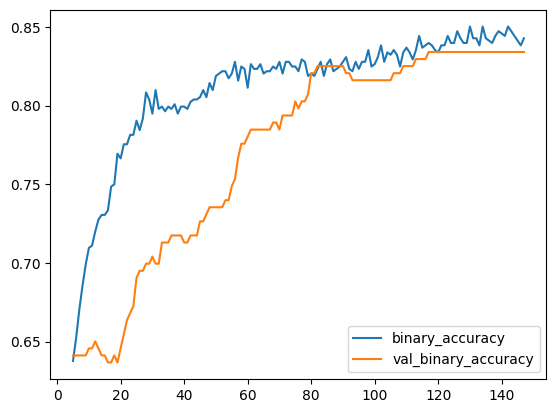

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Set seeds for reproducibility
seed_value = 35643419
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu', input_shape=[train_X2.shape[1]]),
    #layers.Dropout(rate=0.1),
    layers.Dense(16, activation='relu'),
    #layers.Dropout(rate=0.1),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_X2, train_y2,
    validation_data=(val_X2, val_y2),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [30]:
predictions = model.predict(val_X2)

# If you want binary predictions (0 or 1), you can round the predictions
binary_predictions = np.round(predictions)
score = accuracy_score(val_y2, binary_predictions)
print(score)
print(classification_report(val_y2, binary_predictions))


7/7 [==============================] - 0s 2ms/step
0.8340807174887892
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       141
           1       0.88      0.63      0.74        82

    accuracy                           0.83       223
   macro avg       0.85      0.79      0.81       223
weighted avg       0.84      0.83      0.83       223



**LOGISTIC REGRESSION**

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X2)
X_test_scaled = scaler.transform(val_X2)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, train_y2)

y_pred = logreg.predict(X_test_scaled)

In [33]:
print(accuracy_score(val_y2, y_pred))
print(classification_report(val_y2, y_pred))

0.8071748878923767
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       141
           1       0.74      0.73      0.74        82

    accuracy                           0.81       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



**TODO**: we can see what happens when we consider the categorical variables to be the ones that recover the less number of survivals. 

# New submission to competition 

In this ocassion we had a problem because there were more levels in 'Ticket' and 'Family' variables in test set than in train set. For this reason maybe this would not imply a great improvement. 

In [34]:
import pandas as pd
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')
titanic_train['Family'] = [c.split(',')[0] for c in titanic_train.Name]
titanic_test['Family'] = [c.split(',')[0] for c in titanic_test.Name]

In [35]:
titanic_train['NewFamily'] = titanic_train['Family'].apply(lambda x: x if x in mostSurvivedFamilies else 'otherFamily')
titanic_test['NewFamily'] = titanic_test['Family'].apply(lambda x: x if x in mostSurvivedFamilies else 'otherFamily')

In [36]:
print(titanic_train['NewFamily'].unique())
print(titanic_test['NewFamily'].unique())
print(set(titanic_train['NewFamily'].unique())-set(titanic_test['NewFamily'].unique()))

['otherFamily' 'Asplund' 'Harper' 'Carter' 'Kelly' 'Richards' 'Baclini']
['Kelly' 'otherFamily' 'Asplund']
{'Baclini', 'Harper', 'Richards', 'Carter'}


We have to modify the titanic_train NewFamily feature.

In [37]:
mostSurvivedTickets2 = ['Kelly','Asplund']
titanic_train['NewFamily'] = titanic_train['Family'].apply(lambda x: x if x in mostSurvivedTickets2 else 'otherTicket')

In [38]:
titanic_train['NewTicket'] = titanic_train['Ticket'].apply(lambda x: x if x in mostSurvivedTickets else 'otherTicket')
titanic_test['NewTicket'] = titanic_test['Ticket'].apply(lambda x: x if x in mostSurvivedTickets else 'otherTicket')

In [39]:
print(titanic_train['NewTicket'].unique())
print(titanic_test['NewTicket'].unique())
print(set(titanic_train['NewTicket'].unique())-set(titanic_test['NewTicket'].unique()))

['otherTicket' '347742' '347077' 'PC 17572' '110152' 'PC 17755' '13502'
 '17421' 'PC 17757' '113760' '29106' '2666' '24160']
['otherTicket' '347077' 'PC 17757' '24160' 'PC 17755']
{'113760', '110152', '2666', '347742', '13502', 'PC 17572', '29106', '17421'}


We have to modify the titanic_train NewTicket feature. 

In [40]:
mostSurvivedTickets2=['347077','PC 17757','24160','PC 17755']
titanic_train['NewTicket'] = titanic_train['Ticket'].apply(lambda x: x if x in mostSurvivedTickets2 else 'otherTicket')

In [41]:
y_train=titanic_train.Survived

X_train=titanic_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','NewFamily','NewTicket']]
X_test=titanic_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','NewFamily','NewTicket']]

X_train2=X_train.copy()
X_test2=X_test.copy()

In [42]:
my_imputer = SimpleImputer()
numerical_cols2 = [cname for cname in X_train2.columns if X_train2[cname].dtype in ['int64', 'float64']]

X_train2[numerical_cols2] = pd.DataFrame(my_imputer.fit_transform(X_train2[numerical_cols2]))
X_train2[numerical_cols2].columns = X_train[numerical_cols2].columns

X_test2[numerical_cols2] = pd.DataFrame(my_imputer.fit_transform(X_test2[numerical_cols2]))
X_test2[numerical_cols2].columns = X_test[numerical_cols2].columns


In [43]:
categorical_cols2 = [cname for cname in X_train2.columns if X_train2[cname].dtype == "object"]
my_imputer = SimpleImputer(strategy='most_frequent')

X_train2[categorical_cols2] = pd.DataFrame(my_imputer.fit_transform(X_train2[categorical_cols2]))
X_train2[categorical_cols2].columns = X_train[categorical_cols2].columns

X_test2[categorical_cols2] = pd.DataFrame(my_imputer.fit_transform(X_test2[categorical_cols2]))
X_test2[categorical_cols2].columns = X_test[categorical_cols2].columns

In [44]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(X_train2[categorical_cols2]))

OH_cols.index = X_train2.index

X_train2.drop(categorical_cols2, axis=1, inplace=True)

X_train2 = pd.concat([X_train2, OH_cols], axis=1)

X_train2.columns = X_train2.columns.astype(str)

In [45]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(X_test2[categorical_cols2]))

OH_cols.index = X_test2.index

X_test2.drop(categorical_cols2, axis=1, inplace=True)

X_test2 = pd.concat([X_test2, OH_cols], axis=1)

X_test2.columns = X_test2.columns.astype(str)

In [46]:
print(X_train2.shape)
print(X_test2.shape)

(891, 18)
(418, 18)


In [47]:
dtm = DecisionTreeClassifier(max_leaf_nodes=50,random_state=35643419)

dtm.fit(X_train2, y_train)

preds = dtm.predict(X_test2)

In [48]:
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId, 'Survived': preds})
output.to_csv('submission2.csv', index=False)

In [49]:
rfm = RandomForestClassifier(n_estimators=400,max_leaf_nodes=50,max_depth=10,min_samples_split=3,random_state=35643419)

rfm.fit(X_train2, y_train)

preds_rf = rfm.predict(X_test2)

In [50]:
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId, 'Survived': preds_rf})
output.to_csv('submission3.csv', index=False)

In [51]:
rfm = RandomForestClassifier(n_estimators=150,max_leaf_nodes=50,max_depth=10,min_samples_split=3,random_state=35643419)

rfm.fit(X_train2, y_train)

preds_rf2 = rfm.predict(X_test2)

In [52]:
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId, 'Survived': preds_rf2})
output.to_csv('submission6.csv', index=False)